In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Lag_Late(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(2*(lag+1), H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000, 2*(lag+1))

        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        final = torch.sigmoid(lin_out.reshape(V.shape[0], V.shape[1]))
        
        return final



In [3]:
batch_size = 20
batch_length = int(50000 / 5 / 5)
H_no = 40
device = torch.device("cuda")
lag = 20

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred_2ms.npy").reshape(-1,batch_length)
V1 = np.load("/media/hdd01/sklee/CA1_clust4-60_aSoma/diff_pred/V_diff_pred_5ms.npy").reshape(-1,batch_length)
V2 = np.load("/media/hdd01/sklee/CA1_clust4-60_aSoma/nona_pred/V_nona_pred_5ms.npy").reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_aSoma/data/spike_train_5ms.npy").reshape(-1,batch_length)

V1-= np.mean(V1)
V2-= np.mean(V2)

V1 = torch.from_numpy(V1)
V2 = torch.from_numpy(V2)
S = torch.from_numpy(S)

V1_lag = np.zeros((V1.shape[0], V1.shape[1], lag)) #(lag,1000,50000)
V2_lag = np.zeros((V2.shape[0], V2.shape[1], lag)) #(lag,1000,50000)

for i in range(lag):
    V1_lag[:,i+1:,i] = V1[:,:-i-1]
    V2_lag[:,i+1:,i] = V2[:,:-i-1]

V1_lag = torch.from_numpy(V1_lag)
V2_lag = torch.from_numpy(V2_lag)

In [4]:
V1_train = V1[:980].float()
V1_test = V1[980:].float().to(device)
V2_train = V2[:980].float()
V2_test = V2[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V1_lag_train = V1_lag[:980].float()
V1_lag_test = V1_lag[980:].float().to(device)
V2_lag_train = V2_lag[:980].float()
V2_lag_test = V2_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Lag_Late(H_no, lag, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

10121


In [6]:
score_list = []

#for i in tnrange(iter_no):
for i in tnrange(10000):    
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)
    batch_V1 = V1_train[batch_idx].to(device)
    batch_V1_lag = V1_lag_train[batch_idx].to(device)
    batch_V2 = V2_train[batch_idx].to(device)
    batch_V2_lag = V2_lag_train[batch_idx].to(device)
    
    batch_V_in = torch.zeros(batch_size, batch_length, 2*(lag+1)).to(device)
    batch_V_in[:,:,0] = batch_V1
    batch_V_in[:,:,1:lag+1] = batch_V1_lag
    batch_V_in[:,:,lag+1] = batch_V2
    batch_V_in[:,:,lag+2:2*lag+2] = batch_V2_lag
    
    S_out = model(batch_V_in)
    loss = bce_criterion(S_out, batch_S)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        V_test_in = torch.zeros(batch_size, batch_length, 2*(lag+1)).to(device)
        V_test_in[:,:,0] = V1_test
        V_test_in[:,:,1:lag+1] = V1_lag_test
        V_test_in[:,:,lag+1] = V2_test
        V_test_in[:,:,lag+2:2*lag+2] = V2_lag_test
        
        test_S_out = model(V_test_in)
        test_loss = bce_criterion(test_S_out, S_test).item()
        
        score_list.append(test_loss)
        print(i, test_loss)

<ipython-input-6-c2f8f0f7a10e>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(10000):


  0%|          | 0/10000 [00:00<?, ?it/s]

0 0.683125913143158
49 0.02224751003086567
99 0.01623988151550293
149 0.0142059326171875
199 0.013134087435901165
249 0.012417666614055634
299 0.011855524964630604
349 0.011466301046311855
399 0.011189461685717106
449 0.010998214595019817
499 0.010889324359595776
549 0.010621276684105396
599 0.010462190955877304
649 0.01028301939368248
699 0.010083111934363842
749 0.009784772992134094
799 0.009680972434580326
849 0.009134508669376373
899 0.008840064518153667
949 0.00919482670724392
999 0.00828319787979126
1049 0.008642556145787239
1099 0.00804205797612667
1149 0.007843528874218464
1199 0.007599628064781427
1249 0.007625221740454435
1299 0.007523290812969208
1349 0.007544388994574547
1399 0.007227117661386728
1449 0.007474550977349281
1499 0.007585953921079636
1549 0.007590476889163256
1599 0.007083201315253973
1649 0.006961422506719828
1699 0.007680217735469341
1749 0.006973929237574339
1799 0.0067888288758695126
1849 0.006943549960851669
1899 0.006815661676228046
1949 0.00665057264268

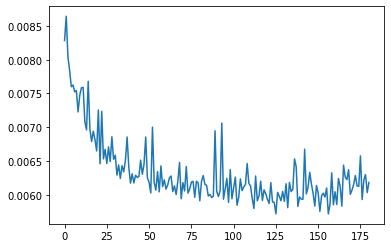

In [7]:
plt.plot(np.asarray(score_list)[20:])

tensor(0.9739, device='cuda:0', grad_fn=<MaxBackward1>)


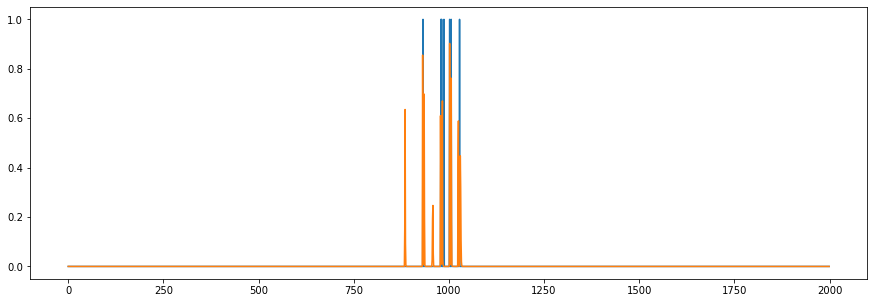

In [8]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy())
plt.plot(test_S_out[1].cpu().detach().numpy())
#plt.xlim(4500,5200)
#plt.ylim(-1,10)
print(torch.max(test_S_out))

In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_aSoma/comb_pred_late/gru_l20_h40_5ms.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_aSoma/comb_pred_late/gru_l20_h40_5ms_test.npy", test_S_out.cpu().detach().numpy())